In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Dataset using Kaggle

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("xhlulu/140k-real-and-fake-faces")

print("Path to dataset files:", path)

Using Colab cache for faster access to the '140k-real-and-fake-faces' dataset.
Path to dataset files: /kaggle/input/140k-real-and-fake-faces


# Imports

In [1]:
!pip install facenet-pytorch

In [2]:
from pathlib import Path
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load

# Pytorch
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
# Facenet
from facenet_pytorch import InceptionResnetV1, MTCNN

# Sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

# Setup

In [5]:
# import os

# for root, dirs, files in os.walk(path):
#     for f in files:
#         print(os.path.join(root, f))

import os

count = 0
for root, dirs, files in os.walk(path):
    for f in files:
        if count < 20:
            print(os.path.join(root, f))
            count += 1
        else:
            break
    if count >= 20:
        break

/kaggle/input/140k-real-and-fake-faces/valid.csv
/kaggle/input/140k-real-and-fake-faces/train.csv
/kaggle/input/140k-real-and-fake-faces/test.csv
/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid/fake/W3DVWMWYOI.jpg
/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid/fake/IQEOWSOAID.jpg
/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid/fake/8JL4TYOH6D.jpg
/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid/fake/69FFH5KFY8.jpg
/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid/fake/ZZAA0631IK.jpg
/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid/fake/BDY8YAWSIS.jpg
/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid/fake/XKHWRIM64I.jpg
/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid/fake/S579BG249Z.jpg
/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid/fake/BLIFEE55NI.jpg
/kaggle/input/140k-real-and-fake-fa

In [5]:
import os

DATASET_ROOT = f"{path}/real_vs_fake/real-vs-fake"

for split in ["train", "valid", "test"]:
    print(split)
    print(" real:", os.path.exists(f"{DATASET_ROOT}/{split}/real"))
    print(" fake:", os.path.exists(f"{DATASET_ROOT}/{split}/fake"))


train
 real: True
 fake: True
valid
 real: True
 fake: True
test
 real: True
 fake: True


In [6]:
# Data_dir = "/content/drive/MyDrive/Colab Notebooks/CS 613-001 ML/Final Project/output/real_and_fake_face"
# REAL_FACE = f"{Data_dir}/training_real"
# FAKE_FACE = f"{Data_dir}/training_fake"

Device = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
IMG_SIZE = 160 #for RENET Input
EMBED_SAVE = "/content/drive/MyDrive/Colab Notebooks/CS 613-001 ML/Final Project/output/embeddings.npz"

# Getting the Dataset and Converted to RGB

In [22]:
class SimpleImageFolder(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        with Image.open(p) as img:
            img = img.convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx], p

# Collect the file path and identify the labels

In [23]:
def collect_paths(real_dir, fake_dir):
    real_paths = sorted([str(p) for p in Path(real_dir).glob("*") if p.suffix in [".jpg", ".png"]])
    fake_paths = sorted([str(p) for p in Path(fake_dir).glob("*") if p.suffix in [".jpg", ".png"]])

    paths = real_paths + fake_paths
    labels = [1] * len(real_paths) + [0] * len(fake_paths) # real = 1 & fake = 0

    return paths, labels

# Feature Extractor (ResNet18)

In [24]:
def get_facenet_embedding_model(device):
    model = InceptionResnetV1(pretrained='vggface2').eval().to(device)
    return model

In [25]:
mtcnn = MTCNN(image_size=160, margin=10, device=Device)  # margin>0 keeps context

def crop_align(path):
    img = Image.open(path).convert('RGB')
    face = mtcnn(img)   # returns a tensor (3,160,160) or None
    return face

# use mtcnn as the header:
def extract_embeddings_mtcnn(paths, labels, device, force_reextract=True):
    if os.path.exists(EMBED_SAVE) and not force_reextract:
        print("Loaded cached embeddings — model loaded.")

        data = np.load(EMBED_SAVE, allow_pickle=True)

        X = np.concatenate([data["X_train"], data["X_test"]])
        y = np.concatenate([data["y_train"], data["y_test"]])

        return X, y, None



    model = InceptionResnetV1(pretrained='vggface2').eval().to(device)
    all_emb, all_labels, all_paths = [], [], []
    for p, lab in tqdm(zip(paths, labels), total=len(paths)):
        face = crop_align(p)
        if face is None:
            # fallback: resize whole image
            img = Image.open(p).convert('RGB').resize((160,160))
            face = transforms.ToTensor()(img)
        face = face.unsqueeze(0).to(device)
        with torch.no_grad():
            emb = model(face).cpu().numpy()
        all_emb.append(emb)
        all_labels.append(lab)
        all_paths.append(p)

    X = np.vstack(all_emb)
    y = np.array(all_labels)
    np.savez_compressed(EMBED_SAVE, X=X, y=y, paths=np.array(all_paths))
    return X, y, np.array(all_paths)

In [26]:
def evaluate_model(clf, X_test, y_test, label_names=["fake", "real"]):
    y_pred = clf.predict(X_test)

    print("\nAccuracy:\n", accuracy_score(y_test, y_pred))

    print("\nPrecision:\n", precision_score(y_test, y_pred))

    print("\nRecall:\n", recall_score(y_test, y_pred))

    print("\nF1:\n", f1_score(y_test, y_pred))

    print("\nReport:\n", classification_report(y_test, y_pred, target_names=label_names))

    cm = confusion_matrix(y_test, y_pred)
    return cm

In [27]:
def plot_confusion(cm, title):
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["fake","real"], yticklabels=["fake","real"])
    plt.title(title); plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()

# Loading Data

In [28]:
global REAL_FACE, FAKE_FACE

# Use train split
BASE = f"{path}/real_vs_fake/real-vs-fake/train"
REAL_FACE = f"{BASE}/real"
FAKE_FACE = f"{BASE}/fake"

In [29]:
paths, labels = collect_paths(REAL_FACE, FAKE_FACE)

In [30]:
X, y, _ = extract_embeddings_mtcnn(paths, labels, device=Device, force_reextract=False)

Loaded cached embeddings — model loaded.


In [31]:
print("Embedding shape:", X.shape)

Embedding shape: (50000, 512)


# Train & Test Split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardization

In [33]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [34]:
X_train.shape

(40000, 512)

In [35]:
X_test.shape

(10000, 512)

# PCA

In [36]:
pca = PCA(n_components=512)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [37]:
print("PCA Components:" , pca.n_components_)

PCA Components: 512


# Training Logistics Regression

In [38]:
lr = LogisticRegression(max_iter=5000)
lr.fit(X_train_pca, y_train)

LogisticRegression(max_iter=5000)


Accuracy:
 0.807

Precision:
 0.8028836658107841

Recall:
 0.8134880928557134

F1:
 0.8081510934393639

Report:
               precision    recall  f1-score   support

        fake       0.81      0.80      0.81      5003
        real       0.80      0.81      0.81      4997

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



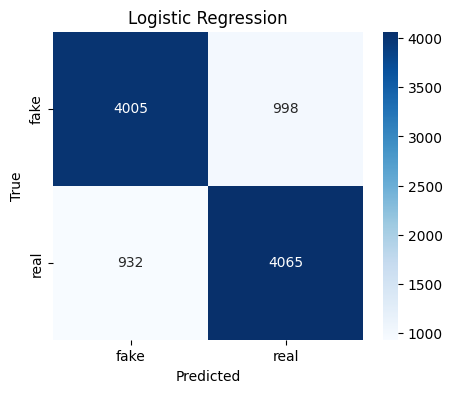

In [39]:
cm_lr = evaluate_model(lr, X_test_pca, y_test)
plot_confusion(cm_lr, "Logistic Regression")

# Training Support Vector Machine (SVM)

In [40]:
# svm = SVC(kernel="rbf", C=3.0, gamma="scale", probability=True)
# svm.fit(X_train_pca, y_train)

svm = CalibratedClassifierCV(LinearSVC())
# svm = CalibratedClassifierCV(SVC(kernel='rbf', C=3.0, gamma='scale'))
svm.fit(X_train, y_train)

# svm = SVC(kernel="linear", probability=True)
# svm.fit(X_train, y_train)

CalibratedClassifierCV(estimator=LinearSVC())


Accuracy:
 0.8469

Precision:
 0.8415451320457233

Recall:
 0.8545127076245748

F1:
 0.8479793466388641

Report:
               precision    recall  f1-score   support

        fake       0.85      0.84      0.85      5003
        real       0.84      0.85      0.85      4997

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



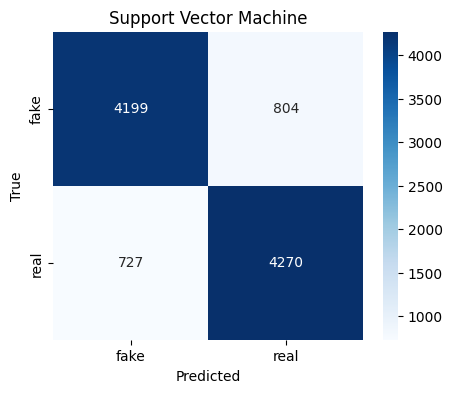

In [41]:
cm_svm = evaluate_model(svm, X_test, y_test)
plot_confusion(cm_svm, "Support Vector Machine")

In [42]:
dump(svm, "/content/drive/MyDrive/Colab Notebooks/CS 613-001 ML/Final Project/output/svm_model.joblib")

['/content/drive/MyDrive/Colab Notebooks/CS 613-001 ML/Final Project/output/svm_model.joblib']

In [7]:
svmodel = load("/content/drive/MyDrive/Colab Notebooks/CS 613-001 ML/Final Project/output/svm_model.joblib")

In [ ]:
# from sklearn.kernel_approximation import Nystroem
# from sklearn.linear_model import SGDClassifier
# from sklearn.pipeline import make_pipeline

# feature_map = Nystroem(n_components=500, random_state=42)
# svm_rbf_fast = SGDClassifier(loss="hinge", max_iter=2000)

# model = make_pipeline(feature_map, svm_rbf_fast)
# model.fit(X_train, y_train)

In [ ]:
# cm_svm_fast = evaluate_model(model, X_test, y_test)
# plot_confusion(cm_svm_fast, "Support Vector Machine (Fast)")

# Ensemble

## Random Forest

In [ ]:
# rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=1)
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train_pca, y_train)

In [ ]:
cm_rf = evaluate_model(rf, X_test_pca, y_test)
plot_confusion(cm_rf, "Random Forest")

## Ensemble (Soft Voting)

In [ ]:
ensemble = VotingClassifier(estimators=[
    ("lr", lr),
    ("svm", svmodel),
    ("rf", rf)],
                            voting="hard")
ensemble.fit(X_train_pca, y_train)

In [ ]:
cm_ens = evaluate_model(ensemble, X_test_pca, y_test)
plot_confusion(cm_ens, "Ensemble")

In [ ]:
models = ["LR", "SVM", "RF", "Ensemble"]
accs = [accuracy_score(y_test, lr.predict(X_test_pca)),
        accuracy_score(y_test, svmodel.predict(X_test_pca)),
        accuracy_score(y_test, rf.predict(X_test_pca)),
        accuracy_score(y_test, ensemble.predict(X_test_pca))]

plt.figure(figsize=(8,5))
plt.bar(models, accs)
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.show()

plt.savefig("/content/drive/MyDrive/Colab Notebooks/CS 613-001 ML/Final Project/output/models.png")

# Prediction

In [8]:
mtcnn = MTCNN(image_size=160, margin=10, device=Device)

In [9]:
embedder = InceptionResnetV1(pretrained='vggface2').eval().to(Device)

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [10]:
def predict_embedding(img_path, model, device):
    img = Image.open(img_path).convert('RGB')
    face = mtcnn(img)
    # face = transforms.Resize((160,160))(img)

    if face is None:
        img = img.resize((160,160))
        face = transforms.ToTensor()(img)

    face = face.unsqueeze(0).to(device)

    with torch.no_grad():
        emb = embedder(face).cpu().numpy()

    pred = model.predict(emb)[0]
    prob = model.predict_proba(emb)[0]

    return {
        "Prediction": "Real" if pred == 1 else "Fake",
        "Fake Probability": float(prob[0]),
        "Real Probability": float(prob[1])
    }

In [19]:
pred_img = predict_embedding("/content/1.jpg", svmodel, Device)

In [20]:
pred_img

{'Prediction': 'Real',
 'Fake Probability': 0.2304885284231462,
 'Real Probability': 0.7695114715768537}